In [1]:
import sys
sys.path.append('/users/stan/documents/')
import os
from glob import glob
import copy
import pandas
import numpy as np

from d_code.imaging.io import tifffile
import matplotlib.pylab as plt
from joblib import Parallel, delayed
from collections import defaultdict
from scipy import signal
from time import time
import cPickle as pickle
import spUtils
import seaborn as sns


import graphlab as gl
gl.canvas.set_target('ipynb')
import pandas as pd

sns.set_palette("husl")
sns.set_style("white")
sns.set_context("poster")


%matplotlib inline
#style notebook
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1482266067.log


This non-commercial license of GraphLab Create for academic use is assigned to stanlp86@gmail.com and will expire on November 04, 2017.


# Paths 


In [2]:
slice_ = 4
experiment = 'sp120416a'
qcGitDir = '/Users/Stan/Documents/myPiriform/notebooks/qc/{0}/'.format(experiment)
sframePath = '/Users/Stan/Desktop/{0}/segmentation_slice_{1}/tracesDFfromTrial/sframe_slice_{1}_processed'.format(experiment, slice_)
rawTracesPath = '/Users/Stan/Desktop/{0}/segmentation_slice_{1}/traces_dict.dat'.format(experiment, slice_)
workflowDictPath = '/Users/Stan/Desktop/{0}/workflow_dict_e2_slice{1}.dat'.format(experiment, slice_)
odorInfoPath = '/Users/Stan/Desktop/{0}/odorInfo_e2.dat'.format(experiment)
metadataPath = '/Users/Stan/Desktop/{0}/metadata/{0}_e2_002_015_slice_{1}_channel_0.dat'.format(experiment, slice_)

maskPath = '/Users/Stan/Desktop/{0}/segmentation/{0}_slice_{1}_maskSoFar.dat'.format(experiment, slice_)


 # save/load

In [3]:
#workflow_dict = pickle.load(open(workflowDictPath))
#rawTraces = pickle.load(open(rawTracesPath))['rois']['reshaped']
def save_dict():
    pickle.dump(workflow_dict, open(workflowDictPath, 'wb'))

In [5]:
slice_5 = pickle.load(open('/Users/Stan/Desktop/slice_5_trials_4_9.dat'))
slice_4 = pickle.load(open('/Users/Stan/Desktop/slice_4_trials_4_9.dat'))

In [7]:
slice_4.cellID.unique()
slice_5.cellID.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74])

In [8]:
df = slice_4.append(slice_5)

In [23]:
groups = df.groupby(['slice','cellID'])

In [24]:
counter = 0
newGroups = []
for key, group in groups:
    group['adjustedCellID'] = counter
    newGroups.append(group)
    counter+=1
newdf = pd.concat(newGroups) 

/Users/Stan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
epoch = newdf.groupby(['trial', 'adjustedCellID']).apply(lambda x: x.reset_index(drop = True))

# get dimensions 
#frames, cells, trials = [epoch.loc[(10,1)]['RoiSignal'].size] + [epoch[_].unique().shape[0] for _ in ['cellID','trial']]
numOdors = 23
trialSet = epoch.trial.unique()
cells = epoch.index.get_level_values('adjustedCellID').unique().shape[0]
frames =  epoch.Frame.unique().shape[0]*numOdors
trials = 6

In [332]:
# epochID = 2
# sliceID = slice_
# sframe = gl.SFrame(sframePath)
# good_trials = [4,5,6,7,8,9]

# sframe['slice'] = sliceID
# df = sframe[(sframe['epoch']==epochID) &(sframe['slice']==sliceID)]['Frame', 'RoiSignal', 'cellID', 'trial', 'normed_traces', 'normed_stds', 'baselined1_traces', 'slice'].to_dataframe()
# df = df.loc[df.trial.isin(good_trials)]
# epoch = df.groupby(['trial', 'cellID']).apply(lambda x: x.reset_index(drop = True))

# # get dimensions 
# #frames, cells, trials = [epoch.loc[(10,1)]['RoiSignal'].size] + [epoch[_].unique().shape[0] for _ in ['cellID','trial']]
# numOdors = 23
# trialSet = epoch.trial.unique()
# cells = epoch.index.get_level_values('cellID').unique().shape[0]
# frames =  epoch.Frame.unique().shape[0]*numOdors
# trials = 6

 ## Make sure ordering is correct for traces. 

/Users/Stan/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


NameError: name 'rawTraces' is not defined

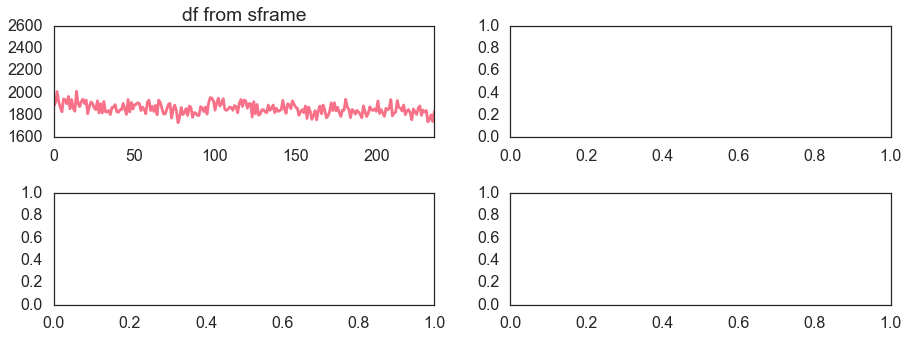

In [5]:
cell = 10
trialID = 6
trialIdx = next(_ for _ in range(trials) if trialSet[_] == trialID)
epochID = 2
sframeTrace = sframe[(sframe['epoch']==epochID)&(sframe['trial']==trialID)&(sframe['cellID']==cell)]['RoiSignal']

plt.subplots(2,2, figsize = (15,5))
plt.subplot(2,2,1),plt.plot(df[df.trial==trialID][df.cellID==cell].RoiSignal.values), plt.xlim(0,236)
plt.title('df from sframe')
plt.subplot(2,2,2), plt.plot(rawTraces[:,cell,trialIdx]), plt.xlim(0,236)
plt.title('recombined traces from orchestra')

plt.subplot(2,2,3), plt.plot(sframeTrace), plt.xlim(0,236)
plt.title('locally recombined traces using sframe')

## Initialize dict

In [27]:
workflow_dict = defaultdict(dict)
# workflow_dict['raw_traces'] = traces
# workflow_dict['numCells'] = traces.shape[1]
# workflow_dict['numTrials'] = traces.shape[2]
# workflow_dict['numOdors'] = 8 #change this line
# workflow_dict['normed_traces']['corrected_rois'] = 
# workflow_dict['normed_traces']['normed_stds'] =

Get trialNames from traces dataframe and make sure it corresponds with odor_info

# Load odor info


In [28]:
odor_info = pickle.load(open(odorInfoPath))['epoch2']
odor_info = odor_info[3:9]
trialIDList = []
for trial in odor_info:
    trialIDList.append(trial['trialID'])

In [29]:
#Correspondence Check
list(epoch.trial.unique()) == trialIDList

True

In [30]:
trialIDList

[4, 5, 6, 7, 8, 9]

In [31]:
trialIndexingHelper = zip(range(len(trialIDList)),trialIDList)

In [32]:
trialIndexingHelper

[(0, 4), (1, 5), (2, 6), (3, 7), (4, 8), (5, 9)]

In [33]:
    
workflow_dict['odor_info']= odor_info

## populate raw traces

In [34]:
trialIDList

[4, 5, 6, 7, 8, 9]

In [35]:
traces = np.empty((trials,cells,frames))
for itrial, trialID in enumerate(trialIDList):
    traces[itrial,:,:] =  np.squeeze(epoch.loc[trialID][['RoiSignal']].to_panel().as_matrix())
traces = traces.T
workflow_dict['raw_traces'] = traces


## populate normed traces

In [36]:
normed_traces = np.empty((trials, cells, frames))
for itrial, trialID in enumerate(trialIDList):
    normed_traces[itrial,:,:] =  np.squeeze(epoch.loc[trialID][['normed_traces']].to_panel().as_matrix())
normed_traces = normed_traces.T
workflow_dict['normed_traces']['corrected_rois'] = normed_traces

## populate normed_stds

In [38]:
normed_stds = np.empty((cells,trials))
this = epoch.groupby(['trial', 'adjustedCellID']).apply(lambda x: x['normed_stds'].ix[0])
for itrial, trialID in enumerate(trialIDList):
    for cell in range(cells):
        normed_stds[cell,itrial] = this.loc[trialID, cell]
workflow_dict['normed_traces']['normed_stds'] = normed_stds

## populate baselines1 for SNR

In [39]:
baselines1 = np.empty((trials, cells, frames))
for itrial, trialID in enumerate(trialIDList):
        baselines1[itrial,:,:] = np.squeeze(epoch.loc[trialID][['baselined1_traces']].to_panel().as_matrix())
baselines1 = baselines1.T
workflow_dict['normed_traces']['baselines1'] = baselines1

## populate other

In [40]:
workflow_dict['numCells'] = cells
workflow_dict['numTrials'] = trials
workflow_dict['numOdors'] = 23

# get responders

In [41]:
workflow_dict['normed_traces']['corrected_rois'].shape


(5382, 149, 6)

In [42]:
from spUtils.FindSigResponses.sigTesting import getcellsBasic
numOdors = workflow_dict['numOdors']
numCells = workflow_dict['numCells']
numTrials = workflow_dict['numTrials']
normed_traces=workflow_dict['normed_traces']['corrected_rois']
window = 16 #frames... 2 seconds. 
responseDict = defaultdict(dict)

for cell in range(numCells):
    for odor in range(numOdors):
        
       
        responseDict[odor][cell] =  [trial for trial in getcellsBasic(workflow_dict, normed_traces, odor, cell, numTrials, window)]
        

In [45]:
#report number of trials (and identity) on which a response is detected. Typically 50% of trials for trial_thresh
trial_thresh = 2
def filterSigCells(responseDict, odor, trial_thresh = trial_thresh):
    for cell, numTrials in responseDict[odor].items():
        if len(numTrials)>=trial_thresh:
            
            yield cell, numTrials


ResponsiveCellsbyOdor = {odor:{cell:numTrials for cell, numTrials in filterSigCells(responseDict, odor, trial_thresh)} for odor in range(numOdors)}# changwe range for new setup


# Fraction of responsive population by odor

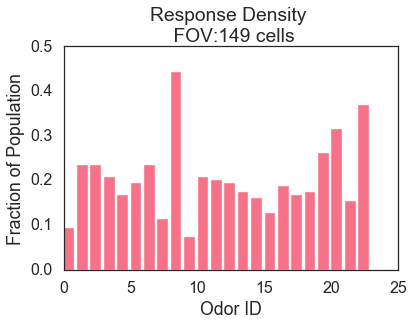

In [46]:

#report number of neurons that satisfy response criterion above. then take fraction.
FractionofPopulation= {key:len(numResponsiveCells) for key, numResponsiveCells in ResponsiveCellsbyOdor.iteritems()}
fractionofCells = np.asarray(FractionofPopulation.values())/float(numCells)
odorID = [odorIDX+1 for odorIDX in FractionofPopulation.keys()]

#Plot
plt.bar(FractionofPopulation.keys(), fractionofCells)#change odor range for new setup
plt.xlabel('Odor ID')
plt.ylabel('Fraction of Population')
plt.ylim(0,0.5)
plt.title('Response Density \n FOV:{} cells'.format(numCells))
plt.savefig('response_density_slice_{}.png'.format(slice_), dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)

## Fraction of responsive population by odor 
- sorted by positive and negative changes. 


In [251]:
#number of detected deviations during odor period on 'trial_thresh' trials deems this a responding odor-cell pair.
trial_thresh = 3

In [252]:
def posSigCells(responseDict, odor, trial_thresh = 2):
    for cell, numTrials in responseDict[odor].items():
        if len(numTrials)>=trial_thresh:
            if sum(x>0 for x in numTrials)>=trial_thresh:
                yield cell, numTrials
def negSigCells(responseDict, odor, trial_thresh = 2):
    for cell, numTrials in responseDict[odor].items():
        if len(numTrials)>=trial_thresh:
            if sum(x<0 for x in numTrials)>=trial_thresh:
                yield cell, numTrials                
                

pos_responders = {odor:{cell:numTrials for cell, numTrials in posSigCells(responseDict, odor, trial_thresh)} for odor in range(numOdors)}# changwe range for new setup
pos_cells = {odor:len(cell_list) for odor, cell_list in pos_responders.iteritems()}
fractionofPosCells = np.asarray(pos_cells.values())/float(numCells)
#print fractionofPosCells

neg_responders = {odor:{cell:numTrials for cell, numTrials in negSigCells(responseDict, odor, trial_thresh)} for odor in range(numOdors)}# changwe range for new setup
neg_cells = {odor:len(cell_list) for odor, cell_list in neg_responders.iteritems()}
fractionofNegCells = np.asarray(neg_cells.values())/float(numCells)

#print fractionofNegCells

# plt.figure(figsize = (5,5))
# plt.bar(range(numOdors), sorted(fractionofPosCells), color =  'k', alpha = 0.5, label = 'excitatory')
# plt.bar(range(numOdors), sorted(fractionofNegCells), alpha = 0.5, label = 'suppressed') #change odor range for new setup
# plt.legend()
# #plt.ylim(0,0.2)
# plt.xlabel('Odor ID')
# plt.ylabel('Fraction of Population')
# plt.title('Response Density \n FOV:{} cells'.format(numCells))
#plt.savefig('ei_response_density.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)


# Promiscuous Cells. Those that respond to more than one odor. 
-This is calculated on cells that respond to an odor on at least 50 percent of the trials. 

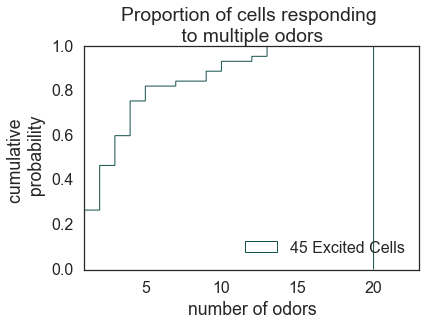

In [253]:
#obtain number of times a responding neuron was reliably detected upon presentations of multiple stimulii.

PosPromiscuousCells = defaultdict(int)
NegPromiscuousCells = defaultdict(int)
for odor in range(numOdors):
    for cell in pos_responders[odor].keys():   
        PosPromiscuousCells[cell] +=1
    for cell in neg_responders[odor].keys():  
        NegPromiscuousCells[cell] +=1
        
        
PosTotal = len(PosPromiscuousCells.values())
NegTotal = len(NegPromiscuousCells.values())


with sns.color_palette('cubehelix', 3):
    plt.hist(PosPromiscuousCells.values(), bins = list(set(PosPromiscuousCells.values())),
             histtype = 'step', linewidth = 1, cumulative = 1, normed = True, label = '{} Excited Cells'.format(PosTotal))
    plt.ylim(0,1)
    plt.xlim(1,23)
    plt.legend(loc='lower right')
#     plt.hist(NegPromiscuousCells.values(), bins = list(set(PosPromiscuousCells.values())), 
#              histtype = 'step', linewidth = 1, cumulative = 1, normed = True, label = '{} Suppressed Cells'.format(NegTotal))
#     plt.ylim(0,1)
#     plt.legend(loc = 'lower right')
    plt.title('Proportion of cells responding \n to multiple odors ')
    plt.xlabel('number of odors')
    plt.ylabel('cumulative \n probability')
    

plt.savefig('cells_across_odors_slice_{}.png'.format(slice_), dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)

In [248]:
# pickle.dump(sp050515a, open('/users/stan/desktop/050515/traces/sp050515a_workflow.dict','wb'))

# Events

In [47]:
from spUtils.get_normalized_traces_submodule import epoch_event_generator, findEventsParams

In [48]:
numSlices = 8 #6 slices + 2 flyback frames
meta = pickle.load(open(metadataPath))
secPerFrame = meta['scanimage.SI5.scanFramePeriod'][0]
frameRate = secPerFrame
findEventsParams['minimum_length'] = int(1/frameRate/numSlices)

In [49]:
normed_traces = next(spUtils.gen_dict_extract('corrected_rois', workflow_dict))
stds = workflow_dict['normed_traces']['normed_stds']#next(spUtils.gen_dict_extract('normed_stds', workflow_dict))
numTrials = workflow_dict['numTrials']
frames, cells, trials = normed_traces.shape

events=defaultdict(dict)
for key, val in [('pos_events',True), ('neg_events',False)]:
    findEventsParams['positive'] = val
    events[key] = epoch_event_generator(normed_traces, stds, cells, numTrials,**findEventsParams)

#store events and params
workflow_dict['events'] = events
workflow_dict['events']['params'] = findEventsParams
# save dict at this point
#save_dict()

KeyboardInterrupt: 

#  Display distribution of event magnitudes  

In [29]:
from spUtils.get_normalized_traces_submodule import getMaxEvents

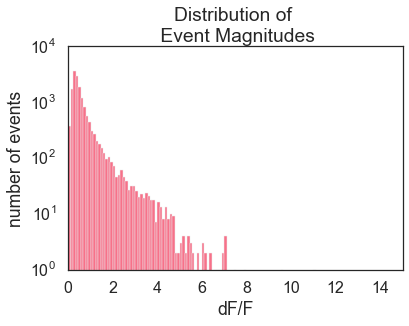

In [30]:
numCells = workflow_dict['numCells']
these_traces = normed_traces
these_events = workflow_dict['events']['pos_events']
    
eMags = getMaxEvents(these_events[:,:,:],these_traces[:,:,:])
workflow_dict['events']['max_events'] = eMags
#since each detected event consists of multiple identical contiguous values. The number of values corresponds to event length.
#the value corresponds to the average of the avent amplitude. 

eMags = list(np.unique(eMags[:,cell,:])[1:] for cell in range(numCells))
eMags_pooled = np.hstack(eMags)

plot = plt.hist(eMags_pooled, bins = 100, log = True)
plt.xlim(0, 15)
plt.title('Distribution of \n Event Magnitudes')
plt.xlabel('dF/F')
plt.ylabel('number of events')
plt.savefig('event_magnitudes_slice_{}.png'.format(slice_), dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)


#  Display distribution of event durations  

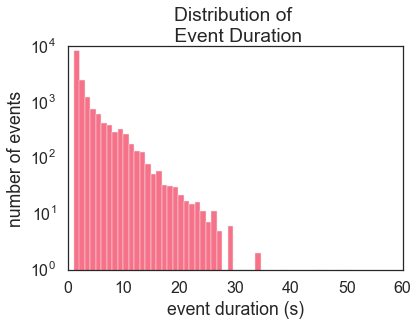

In [31]:
from  d_code.events import getStartsAndStops
from numpy import ma
from d_code.events import getDurations
#posDur = ma.getdata(getDurations(events['pos_events']))


posDur = getDurations(workflow_dict['events']['pos_events'])
condition = np.isfinite(posDur)
pos_event_durations = (np.extract(condition, posDur))#/fps
workflow_dict['events']['event_durations'] = pos_event_durations 
#ytick_list = [("%.2f" % a) for a in np.asarray(range(0,36292,4500))/float(PosTotal)]
#plt.hist(pos_event_durations/one_second, normed = True)
one_second = 1/secPerFrame/numSlices
plot = plt.hist(pos_event_durations/one_second, bins = 50,log = True,)
plt.xlim(0,60)
#plt.yticks(range(0,36292,4500), ytick_list)

#plt.hist(pos_event_durations/10.)

plt.title('Distribution of \n Event Duration')
plt.ylabel('number of events')
plt.xlabel('event duration (s)')

plt.savefig('normed_event_duration_slice_{}.png'.format(slice_), dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)

# Investigate outlier events.
- Ultimately, event-detection should not bias against an event of a particular duration. 

In [218]:
starts, stops = getStartsAndStops(workflow_dict['events']['pos_events'])

In [459]:
exceptionalEventDurations = np.argwhere(posDur/one_second>20)

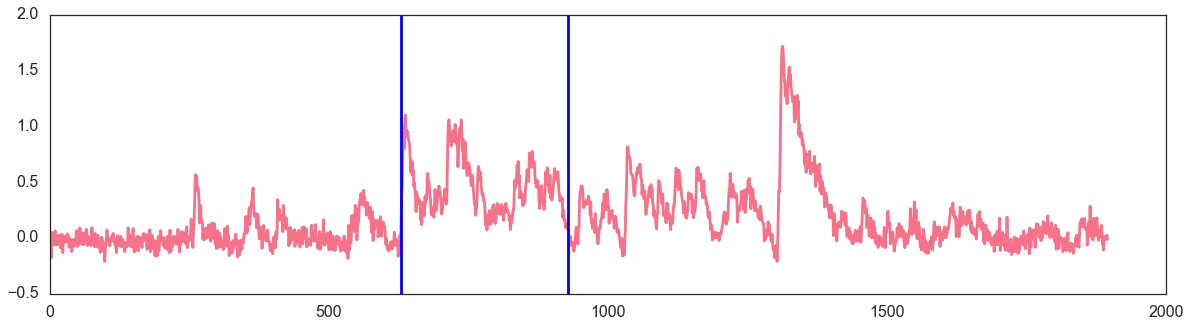

In [464]:

exceptionalEventDurations = np.argwhere(posDur/one_second>20)
eventID =5
cell, trial, this_event = exceptionalEventDurations[eventID]
duration = posDur[cell, trial, this_event]
i = starts[cell, trial, this_event]
j = stops[cell, trial, this_event]

#plot
plt.figure(figsize = (20,5))
plt.plot(normed_traces[:,cell,trial])
plt.axvline(i)
plt.axvline(j)

In [32]:
save_dict()

In [33]:
#All events all trials all cells divided by trial length
trial_length = secPerFrame*numSlices*5382
Average_Event_Frequency = eMags_pooled.shape[0]/(numCells*numTrials)/trial_length#float(PosTotal)
Average_number_of_events_per_cell = eMags_pooled.shape[0]/numCells/numTrials

In [34]:
Average_Event_Frequency

0.070243783579689523

In [35]:
Average_number_of_events_per_cell

52

# Lifetime Sparseness

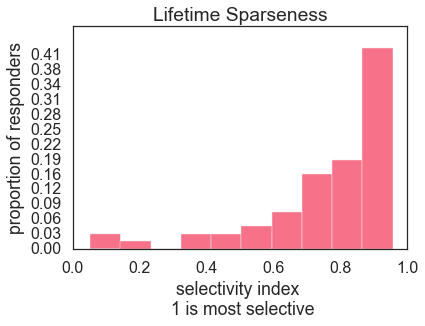

In [36]:
average_response_odor_cell = {'odor_{}'.format(odor) :{cell : np.mean([trials]) for cell, trials in pos_responders[odor].iteritems()} for odor in range(numOdors)}

#average_response_odor_cell = {'odor_{}'.format(odor) :{cell : np.mean([trials]) for cell, trials in neg_responders[odor].iteritems()} for odor in range(23)}

#get all responsive cells
hmm = defaultdict(list)
for odor in range(numOdors):
    hmm['odor_{}'.format(odor)] = [cell_list for cell_list in average_response_odor_cell['odor_{}'.format(odor)].iterkeys()] 
    
blah = hmm.values()
#for responsive cells only, get all resposes. 
c = []
for item in blah:
    c.append(item)
d = set(np.hstack(c))


response_list_by_cell = []

for cell in d: 
    
    a = spUtils.gen_dict_extract(cell, average_response_odor_cell)
    response_list_by_cell.append(np.asarray([item for item in a]))


LS_list = []
for cell, cell_responses in enumerate(response_list_by_cell):
    numerator = np.power(np.sum(np.absolute(cell_responses))/numOdors,2)
    denomenator = np.sum(np.power(cell_responses,2)/float(numOdors))
    LS_list.append(1-float(numerator)/denomenator)
LS_list = np.hstack(LS_list)

#


counts, values = np.histogram(LS_list)
numResponders = LS_list.shape[0]
ytick_interval = 2

plot = plt.hist(LS_list)
ytick_list = [("%.2f" % a) for a in np.asarray(range(0,counts.max(),ytick_interval))/float(numResponders)]
ticks = plt.yticks(range(0,counts.max(),ytick_interval), ytick_list)
plt.title('Lifetime Sparseness')
plt.xlabel('selectivity index \n 1 is most selective')
plt.ylabel('proportion of responders')
plt.savefig('LS_slice_{}.png'.format(slice_), dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)


## Plot trial-averaged responses by odor

### extract odor onset for all trials

In [50]:
odor_info = spUtils.gen_dict_extract('odor_info', workflow_dict).next()

odor_on_times_by_trial = defaultdict(list)
for odor in range(1,numOdors+1):
    for trial in range(numTrials):
        odor_on_times_by_trial[odor].append(odor_info[trial]['on'][odor])
        
odor_off_times_by_trial = defaultdict(list)
for odor in range(1,numOdors+1):
    for trial in range(numTrials):
        odor_off_times_by_trial[odor].append(odor_info[trial]['off'][odor])
        
odor_interval_by_trial = defaultdict(list)
for odor in range(1,numOdors+1):
    for trial in range(numTrials):
        odor_interval_by_trial[odor].append(odor_info[trial]['pre_odor_post_interval'][odor])

In [51]:
def xticksInSec(framerate, secInterval, plotLengthInFrames):
    import numpy as np
    
    plotLengthInFrames = int(plotLengthInFrames)
    secInterval = int(secInterval)
    xtickframetimes = np.arange(0, plotLengthInFrames, framerate*secInterval)
    xtickssectimes = np.arange(0, plotLengthInFrames/framerate, secInterval).astype(int)
    return plt.xticks(xtickframetimes,xtickssectimes)

In [52]:
frameRate = 1/secPerFrame/numSlices

In [53]:
frameRate

7.2702316004978647

In [54]:
odor_names={}
classes  = ['acids', 'esters','aldehydes', 'ketones', 'thiazoles', 'sulfers']
molecules= [['hexanoic acid', 'heptanoic acid', 'octanoic acid'], 
            ['isoamyl acetate',
                'amyl acetate',
                'hexyl acetate',
                'butyl acetate',],
           ['propanal',
            'butanal',
            'heptanal',
            'octanal'],
            ['2-pentanone',
            '2-heptanone',
            '4-heptanone',
            '2-octanone'],
            ['2,4,5-trimethylthiazole',
            '4-methylthiazole',
            '5-methylthiazole'],
           ['2-mercaptoethanol',
            '1,2-ethanedithiol',
            'carbon disulfide',
            'dimethyl disulfide']]
j = 2
for i, class_ in enumerate(classes):
    odor_names[class_] =[]
    for odor in molecules[i]:
        odor_names[class_].append((odor, j))
        j+=1

In [65]:
normed_traces= workflow_dict['normed_traces']['corrected_rois']

In [61]:
reordered = list(np.random.permutation(149))

In [62]:
normed_traces = normed_traces[:,reordered,:]

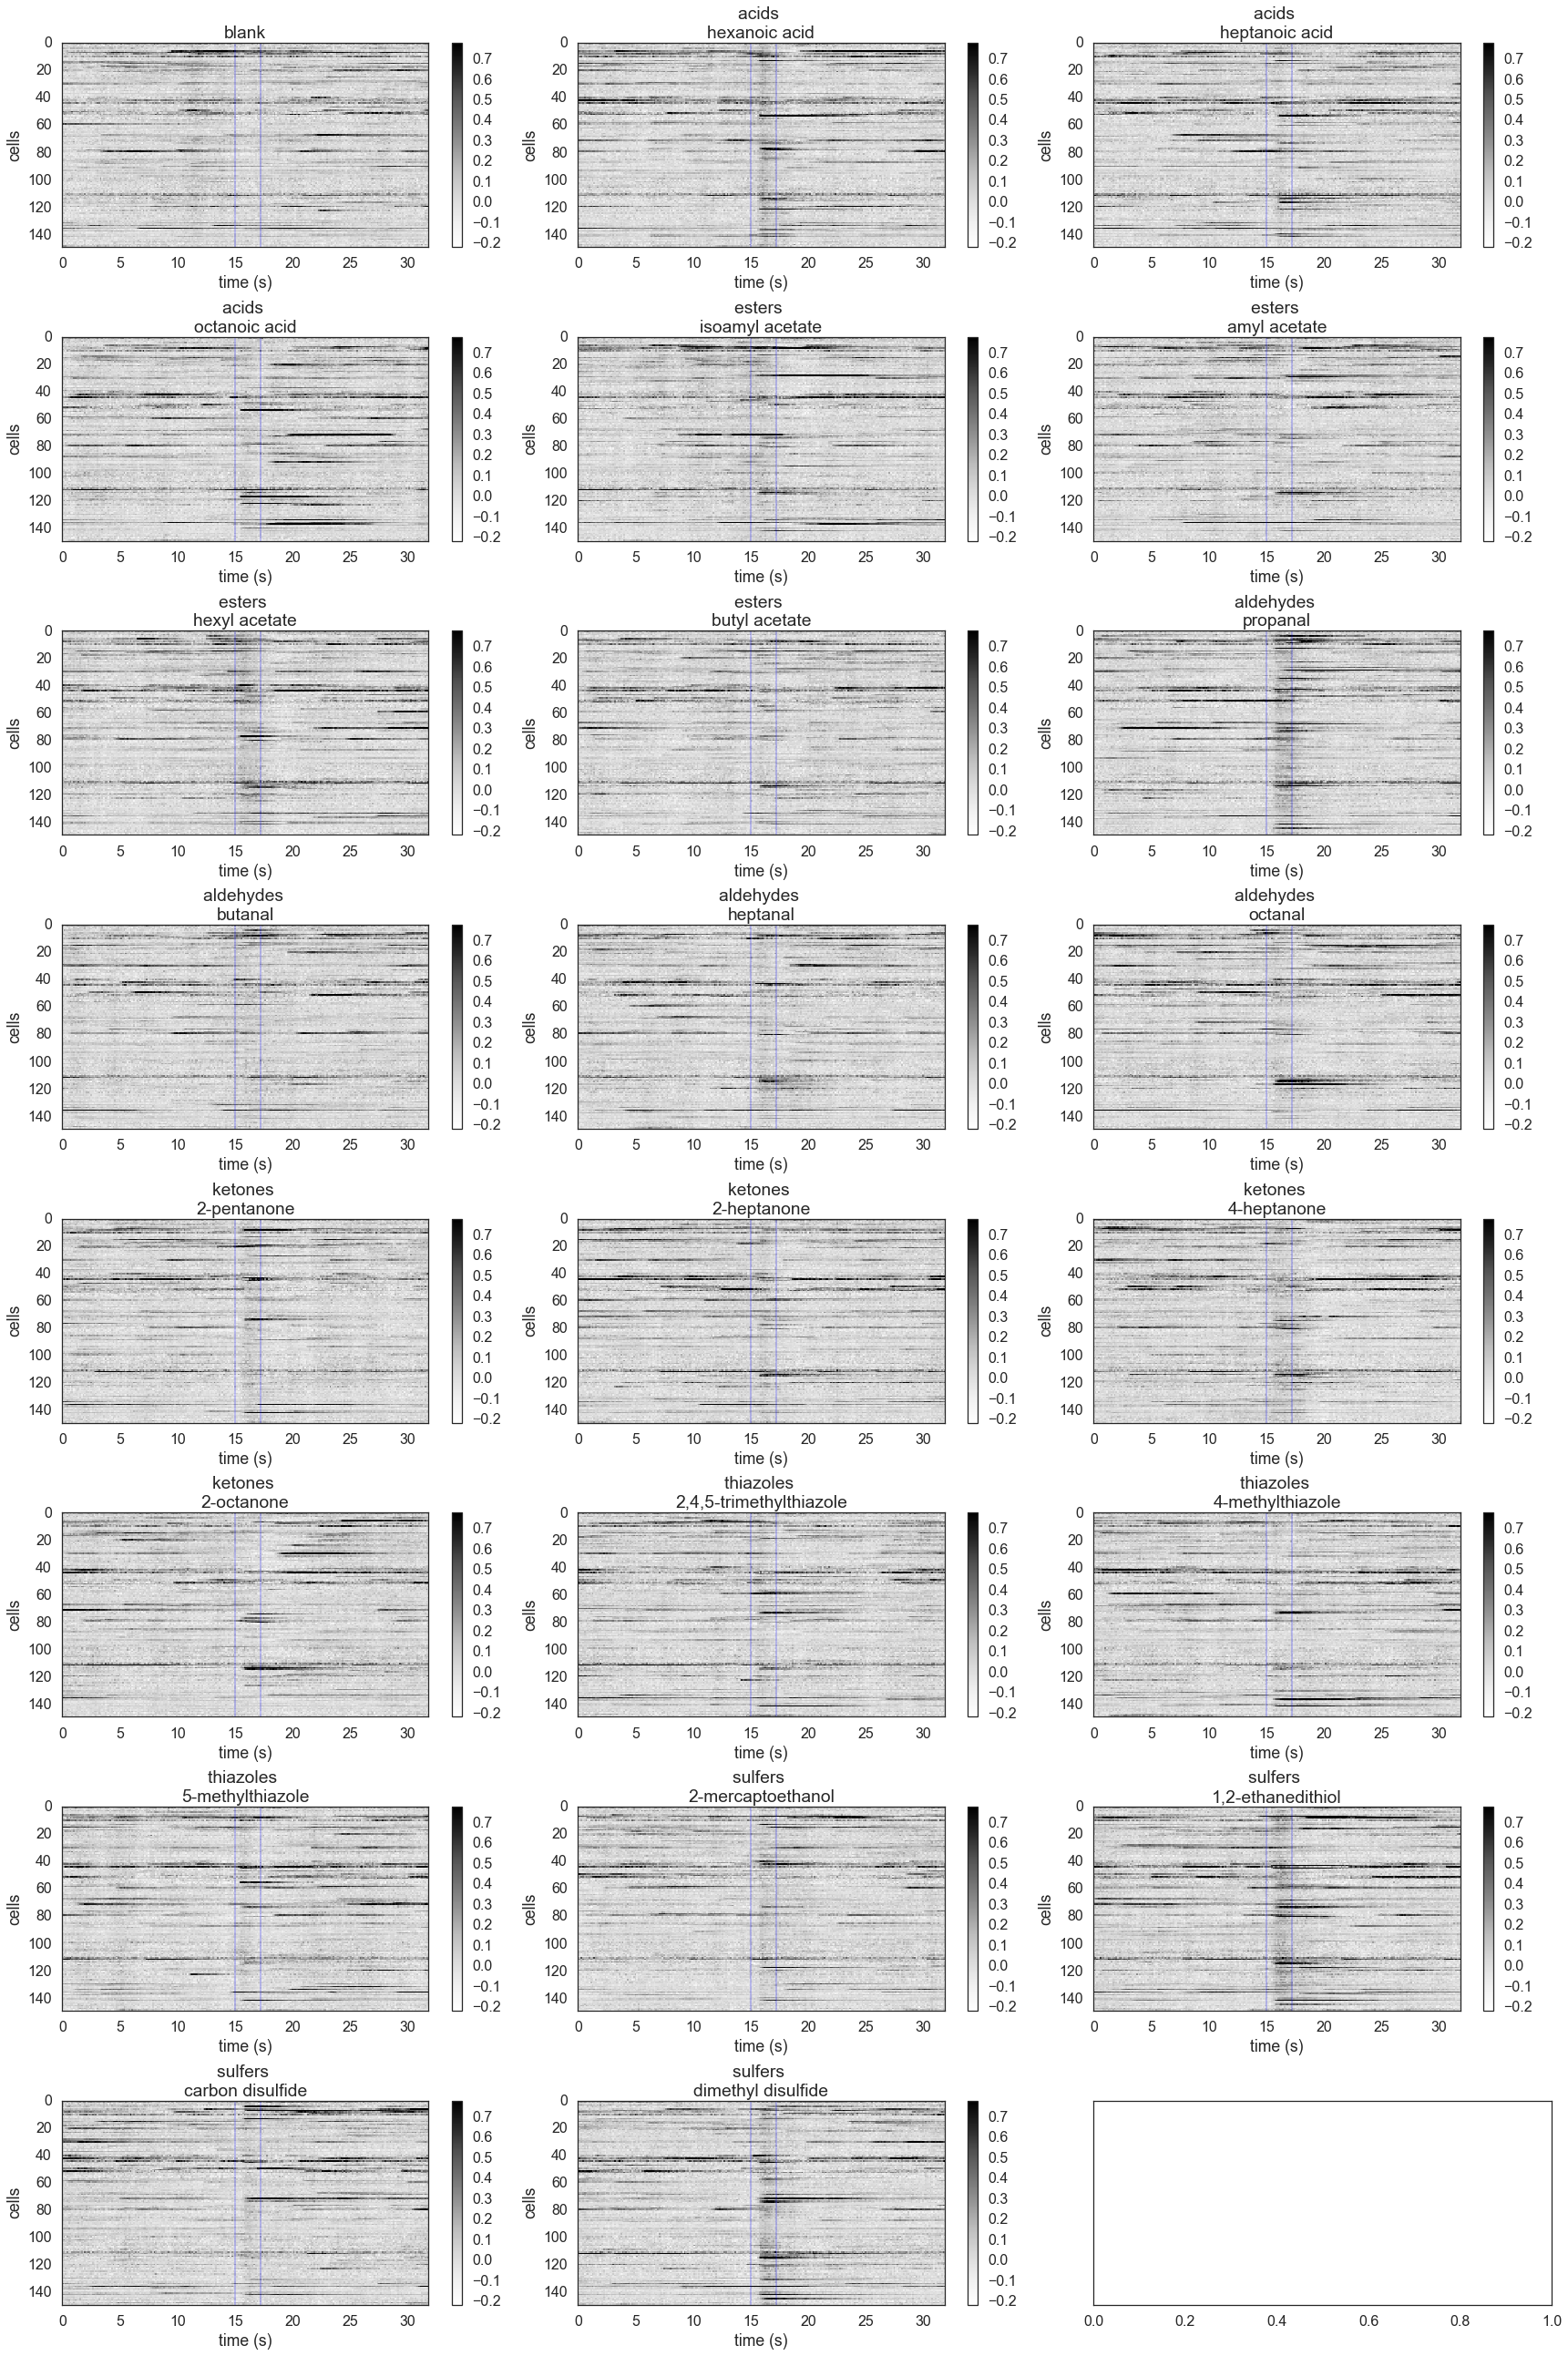

In [67]:
from scipy.stats.mstats import mquantiles
min_, max_ = mquantiles(normed_traces[...,:].flatten(),  prob=[0.02, .98])
offset = 109
nro=(numOdors+1)/3
nco=3
plt.subplots(nro,nco, sharex=True, sharey=True, figsize = (3*nro,12*nco))
for idx, odor in enumerate(range(1,numOdors+1)):
    aa = []
    title = 'blank'#odor_info[0]['odor_names'][idx][1]
    for class_ in classes:    
        for name in odor_names[class_]:
            if name[1]==odor:
                title =  '{} \n'.format(class_) + name[0]
    for trial in range(numTrials):
        sta, sto  = odor_interval_by_trial[odor][trial]
        test  = slice(sta,sto,1)
        
        aa.append(normed_traces[test,:,trial][:232,:])
    aa = np.dstack(aa)
    plt.subplot(nro,nco,idx+1)
    plt.title(title)
    
    plot = plt.imshow(aa.mean(2).T, aspect = 'auto', vmin = min_,vmax = max_)
    plt.ylabel('cells')
    plt.xlabel('time (s)')
    plt.colorbar()
    xticksInSec(framerate = frameRate, secInterval = 5, plotLengthInFrames = 232)
    #plt.clim(0,2)
    plt.axvline(offset, linewidth = 0.4)
    plt.axvline(offset+16, linewidth = 0.4)
plt.tight_layout()
plt.savefig('AveRespsbyOdor_slice_{}_both.png'.format(slice_), dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)

### odor-cell pairs by trial by odor

In [45]:

# odor_info[0]['odor_names'] = range(1,8+1)

In [ ]:
# idxs = np.vstack(odor_interval_by_trial[odor])

# nro=numOdors/2
# nco=2


# for trial in range(numTrials)[:]:
#     fig,b = plt.subplots(nro,nco, sharex=True, sharey=True, figsize = (3*nro,5*nco))
#     fig.suptitle('Trial {}'.format(trial+1), y = 1.05, fontsize=32)
#     for idx, odor in enumerate(range(1,numOdors+1)):
        
#         title = odor_info[0]['odor_names'][idx]#[1]
#         sta, sto  = odor_interval_by_trial[odor][trial]
#         test  = slice(sta,sto,1)
#         this_trial = normed_traces[test,:,trial]

#         plt.subplot(nro,nco,idx+1)
#         plt.title(title)
#         v = plt.imshow(this_trial.T, aspect = 'auto')
#         plt.clim(0,3)
#         plt.axvline(offset)
#         plt.axvline(offset+15)
#         plt.tight_layout()
#     plt.savefig('/users/stan/desktop/temp/temp_{}.png'.format(trial), dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)
#     plt.close()

In [94]:
# from moviepy.editor import *
# files=glob('/Users/Stan/Desktop/temp/'+'*.png')
# files = sorted(files, key = lambda fname: int(fname.split('_')[-1].split('.png')[0]))
# clip = ImageSequenceClip(files, fps=1)
# # #ipython_display(clip)
# clip.write_videofile("/Users/Stan/Desktop/temp/e1_OdorTrialRasters.mp4",fps=1, codec='mpeg4')

[WARNING] /Users/Stan/anaconda/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



[MoviePy] >>>> Building video /Users/Stan/Desktop/temp/e2_OdorTrialRasters.mp4
[MoviePy] Writing video /Users/Stan/Desktop/temp/e2_OdorTrialRasters.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: /Users/Stan/Desktop/temp/e2_OdorTrialRasters.mp4 



### SNR

In [321]:
from spUtils import getSNR
from spUtils.get_normalized_traces_submodule import getMaxEvents
from spUtils import getSNR

traces = next(spUtils.gen_dict_extract('baselines1', workflow_dict))
numCells = workflow_dict['numCells']
events = workflow_dict['events']['pos_events']

maxEvents = getMaxEvents(events,traces)

# store events and params
# workflow_dict['events']['max_events'] = maxEvents

# traces = next(spUtils.gen_dict_extract('baselined1_traces', workflow_dict))

# maxEvents = getMaxEvents(events,traces)

# #store events and params
# workflow_dict['events']['max_events_raw'] = maxEvents
# #save_dict()

In [322]:
numTrials

4

4.71185441288


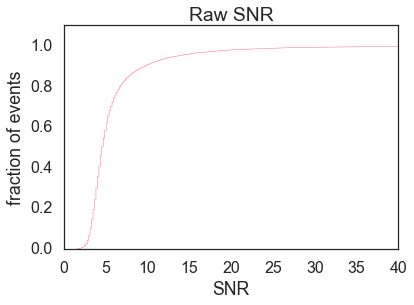

In [323]:
#baselined1 traces
allSNRs = []
for cell in range(1,numCells):
    for trial in range(numTrials):
         allSNRs.append(getSNR(traces,maxEvents,cell,trial))
allSNRs = np.hstack(allSNRs)
allSNRs = np.array(sorted(allSNRs))
print np.percentile(allSNRs,50)

plt.hist(allSNRs, bins = 500, histtype = 'step', cumulative = True, normed = True)
plt.xlim([0,40])
plt.ylim([0,1.1])
plt.title('Raw SNR')
plt.ylabel('fraction of events')
plt.xlabel('SNR')
plt.savefig('SNR_slice_{}.png'.format(slice_), dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)

# Mask

In [328]:

mask = pickle.load(open(maskPath))
fname = '/Users/Stan/Desktop/{0}/h5/green/slice_{1}/_e2_004_concatenated.h5'.format(experiment, slice_)

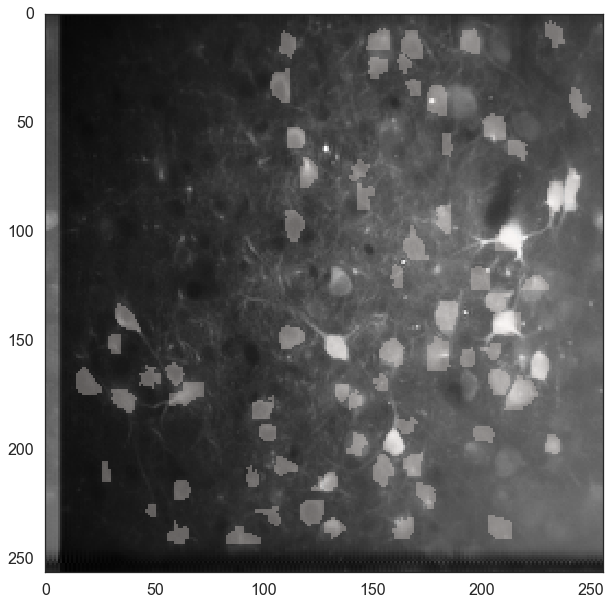

In [329]:
from skimage.util import img_as_ubyte
from skimage.transform import downscale_local_mean as localAve
import h5py
from scipy.stats.mstats import mquantiles

with h5py.File(fname, 'r+', ) as f:
    
    stack = f['_e2_004_'][...]
    
    

stack = img_as_ubyte(stack)
a,b = mquantiles(stack.flatten(),  prob=[0.02, .99])
stack[stack<a] = a
stack[stack>b] = b

subsampleFact = 10
stack = localAve(stack, (1,1,subsampleFact))

x,y,vidframes = stack.shape



from scipy.ndimage.measurements import center_of_mass as get_coords

plt.figure(figsize = (10,10))
overlay = np.ma.MaskedArray(mask.astype(bool), np.invert(mask.astype(bool)).astype(bool))
plt.imshow(stack[...].mean(2), cmap = 'Greys_r')
plt.imshow(overlay, cmap = 'Reds', alpha = 0.3)
#add cell location
#plt.gca().add_patch(plt.Circle(coords[cell],2, alpha = 1))
plt.savefig('mask_slice_{}.png'.format(slice_))

In [330]:
save_dict()

# Single cell movies

## Find cells with strong events, as well as outliers
 - Find those that have at least 3 strong events in a trial, that clear a particular threshold.
 - Thresh: 1.5 


In [51]:

def get_ave_event_by_cell(numCells, maxEventsArray, trialIDX, eventThresh):
    for cell in range(numCells):

        cellEvents = maxEventsArray[:,cell,trialIDX]
        cellEvents = cellEvents[cellEvents>0]
        if len(cellEvents)>3:
            if cellEvents.mean()>eventThresh:
                yield cellEvents.mean(), cell


In [39]:
normed_traces = workflow_dict['normed_traces']['corrected_rois']

In [40]:
numCells = normed_traces.shape[1]

In [48]:
workflow_dict['events']['max_events'][:,:,4].max()

13.850187265917601

In [50]:
actualTrial

6

71 4
actual trial 6


(-0.5, 3)

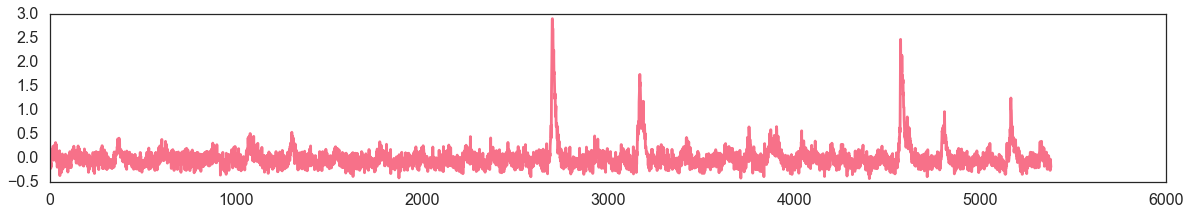

In [52]:
trialIDX = 4
actualTrial = [_[1] for _ in trialIndexingHelper if _[0]==trialIDX][0]

strongCells = [val[1] for val in get_ave_event_by_cell(numCells = numCells, 
                                                       maxEventsArray = workflow_dict['events']['max_events'], 
                                                       trialIDX=trialIDX, 
                                                       eventThresh = 1.0)]
cell = np.random.permutation(strongCells)[0]
#cell = 116

print cell, trialIDX
print 'actual trial', actualTrial

plt.figure(figsize = (20,3))
plt.plot(normed_traces[:,cell,trialIDX])
plt.ylim(-.5,3)

### Define Coords

In [85]:
numCells

52

In [9]:
useTheseCellsForMov = [61,30,64]
#useTheseCellsForMov = strongCells

In [54]:
picDir = "/Users/Stan/Desktop/temp/{0}/slice_{1}/".format(experiment, slice_)
if not os.path.isdir(picDir):
    os.mkdir(picDir)

In [55]:
for _cell in useTheseCellsForMov:
    if _cell == 64:
        makeMov(_cell)
    

64
[MoviePy] >>>> Building video /Users/Stan/Desktop/temp/sp120616a/slice_5/e2_Cell_64_Trial_6.mp4
[MoviePy] Writing video /Users/Stan/Desktop/temp/sp120616a/slice_5/e2_Cell_64_Trial_6.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: /Users/Stan/Desktop/temp/sp120616a/slice_5/e2_Cell_64_Trial_6.mp4 



In [538]:
# 221-185

# trace = sframe[(sframe['slice'] ==4)&(sframe['cellID'] ==36)&(sframe['trial'] ==3)] 

# ntrace = trace['normed_traces']

# coords = (204.9,218.58)

36

In [12]:
def makeMov(_cell):
    import spUtils

    #cell = np.random.permutation(strongCells)[0]
    cell = _cell#cell
    print cell


    coords = scipy.ndimage.measurements.center_of_mass(mask, mask, range(0,int(mask.max())+1))
    convertIdxs = list(np.argwhere(np.isnan(coords))[:,0][::2])
    for i in convertIdxs:
        coords[i]= (0.0,0.0)
    coords = [(int(t[1]),int(t[0])) for t in coords]

    #Specify dimensions and location of zoom window around cell mask
    halfRad = 15
    yi = coords[cell][1]-halfRad
    yf = coords[cell][1]+halfRad
    xi = coords[cell][0]-halfRad
    xf = coords[cell][0]+halfRad



    #process mask overlay
    overlay = np.ma.MaskedArray(mask.astype(bool), np.invert(mask.astype(bool)).astype(bool))

    import matplotlib.gridspec as gridspec
    #from spUtils import xticksInSec

    for frame in range(vidframes)[:]:
        #set display range for zoom window to correspond to that of entire FOV
        colormin = stack[...,frame].min()
        colormax = stack[...,frame].max()

        plt.figure(figsize=(16, 9))
        G = gridspec.GridSpec(4, 2)
        axes_1 = plt.subplot(G[:3, :1])
        axes_2 = plt.subplot(G[3:, :])
        axes_3 = plt.subplot(G[:3, 1:])


        axes_1.imshow(stack[yi:yf,xi:xf,frame], cmap = 'Greys_r',  aspect = 'auto', vmin = colormin, vmax = colormax)
        axes_1.imshow(overlay[yi:yf,xi:xf,], cmap = 'Reds', alpha = 0.35)
        axes_1.add_patch(plt.Circle((halfRad,halfRad),.5, alpha = 1))
        axes_1.set_ylabel('df/F')

        axes_3.imshow(stack[...,frame], cmap = 'Greys_r',  aspect = 'auto')
        axes_3.imshow(overlay, cmap = 'Reds', alpha = 0.35)
        axes_3.add_patch(plt.Circle(coords[cell],5, alpha = 1))
        


        axes_2 = plt.subplot(G[3:, :])
        axes_2.set_title('Cell {0} Trial {1}'.format(cell,actualTrial))
        axes_2.plot(normed_traces[:,cell, trialIDX], linewidth = 0.8)
        axes_2.axvline(range(0,normed_traces.shape[0],subsampleFact)[frame], linewidth = 1)
        axes_2.xticks = spUtils.xticksInSec(framerate = 1/secPerFrame/8, secInterval = 30, plotLengthInFrames = normed_traces.shape[0])
        axes_2.set_ylim((-.2,3))
        axes_2.set_xlabel('sec')
        plt.savefig(picDir + 'pic_{}.png'.format(frame))
        plt.close()
    from moviepy.editor import ImageSequenceClip
    files=glob(picDir +'*.png')
    files = sorted(files, key = lambda fname: int(fname.split('_')[-1].split('.png')[0]))
    clip = ImageSequenceClip(files, fps=1)
    # #ipython_display(clip)
    clip.write_videofile("/Users/Stan/Desktop/temp/{0}/slice_{1}/e2_Cell_{2}_Trial_{3}.mp4".format(experiment, slice_,cell,actualTrial) ,fps=1, codec='mpeg4')

# Extra

In [ ]:
from scipy.stats.mstats import mquantiles

for trial in range(normed_traces.shape[2]):
    min_, max_ = mquantiles(normed_traces[...,trial].flatten(),  prob=[0.001, .999])
    plt.figure(figsize = (20,5))
    plt.imshow(normed_traces[...,trial].T, aspect = 'auto', vmin = min_, vmax = max_)
    plt.title('trial_{}'.format(trial+1))
    plt.colorbar()

# plt.figure(figsize = (20,5))
# plt.imshow(traces[...,trial].T, aspect = 'auto')
# plt.colorbar()

# plt.figure(figsize = (20,5))
# plt.imshow(normed_traces[...,trial].T, aspect = 'auto')
# plt.colorbar()

In [ ]:
#Inspect responder output.

trial = 3
interval = odor_info[trial]['pre_odor_post_interval'][odor+1]
plt.plot(normed_traces[interval[0]:interval[1], cell,trial])
plt.axvline(113)
plt.axvline(128)

In [ ]:
fig = plt.figure(figsize = (20,10))
plt.imshow(traces[:,:,1].T, aspect = 'auto')

In [ ]:
df = epoch.loc[1]['0'].unstack()

In [ ]:
import plotly
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode() # run at the start of every ipython notebook to use plotly.offline
                     # this injects the plotly.js source files into the notebook
    #combine all with seaborn and pandas. 
import cufflinks as cf
cf.go_offline()

In [ ]:
df.T.iplot(kind='heatmap', colorscale='greys', dimensions=(800, 1000))